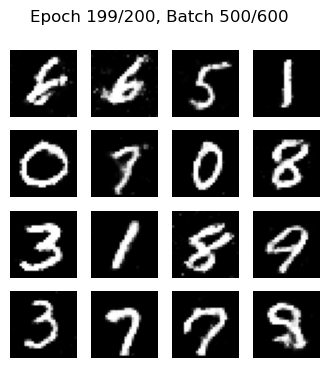

Epoch: 199/200 | Batch: 500/600
D Error: 1.2394 | G Error: 0.9015
D(x): 0.57 | D(G(z)): 0.44


In [2]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from IPython import display
import matplotlib.pyplot as plt
import os

# Create a data directory to store the MNIST dataset
DATA_FOLDER = './torch_data/VGAN/MNIST'
if not os.path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)

def mnist_data():
    """
    Downloads and prepares the MNIST dataset.
    """
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])
        ])
    out_dir = f'{DATA_FOLDER}/dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

# Load data and create a DataLoader
data = mnist_data()
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
num_batches = len(data_loader)

class DiscriminatorNet(torch.nn.Module):
    """
    A three-hidden-layer discriminative neural network.
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

class GeneratorNet(torch.nn.Module):
    """
    A three-hidden-layer generative neural network.
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),          
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

def noise(size):
    """
    Generates a tensor of random noise.
    """
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available():
        return n.cuda()  
    return n

def real_data_target(size):
    """
    Creates a target tensor filled with ones for real data.
    """
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available():
        return data.cuda()
    return data

def fake_data_target(size):
    """
    Creates a target tensor filled with zeros for fake data.
    """
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available():
        return data.cuda()
    return data

def train_discriminator(optimizer, real_data, fake_data):
    """
    Trains the discriminator network.
    """
    optimizer.zero_grad()
    
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    optimizer.step()
    
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    """
    Trains the generator network.
    """
    optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    optimizer.step()
    return error

# Logger class to handle logging and visualization
class Logger:
    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name
        self.epoch_errors = []

    def log_images(self, images, num_samples, epoch, n_batch, num_batches):
        images = images.numpy()
        fig = plt.figure(figsize=(4, 4))
        for i in range(images.shape[0]):
            ax = fig.add_subplot(4, 4, i+1)
            ax.axis("off")
            ax.imshow(images[i, 0], cmap="gray")
        plt.suptitle(f'Epoch {epoch}/{num_epochs}, Batch {n_batch}/{num_batches}')
        plt.show()
        plt.close()

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        print(f'Epoch: {epoch}/{num_epochs} | Batch: {n_batch}/{num_batches}')
        print(f'D Error: {d_error.data.item():.4f} | G Error: {g_error.data.item():.4f}')
        print(f'D(x): {d_pred_real.mean():.2f} | D(G(z)): {d_pred_fake.mean():.2f}')

    def save_models(self, generator, discriminator, epoch):
        save_dir = f'./{self.model_name}_{self.data_name}_models'
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        torch.save(generator.state_dict(), f'{save_dir}/generator_epoch_{epoch}.pth')
        torch.save(discriminator.state_dict(), f'{save_dir}/discriminator_epoch_{epoch}.pth')


# Instantiate models, optimizers, and loss function
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
loss = nn.BCELoss()

num_epochs = 200
num_test_samples = 16
test_noise = noise(num_test_samples)
logger = Logger(model_name='VGAN', data_name='MNIST')

# Main training loop
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available():
            real_data = real_data.cuda()
        
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data)
        
        # Log and display progress
        if (n_batch) % 100 == 0:
            display.clear_output(wait=True)
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches)
            logger.display_status(epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake)
    
    # Save models after each epoch
    logger.save_models(generator, discriminator, epoch)